In [1]:
from constants import TIME_STEPS
from best_configurations_experiment import best_sparsity_model, best_grid_search_model, best_number_hidden_layer_model, best_number_hidden_neurons_model

In [2]:
import torch
import copy

best_sparsity_model_trained = copy.deepcopy(best_sparsity_model)
best_sparsity_model_trained.load_state_dict(torch.load('./models/best_sparsity.pth'))

best_number_hidden_neurons_model_trained = copy.deepcopy(best_number_hidden_neurons_model)
best_number_hidden_neurons_model_trained.load_state_dict(torch.load('./models/best_number_hidden_neurons.pth'))

best_number_hidden_layer_model_trained = copy.deepcopy(best_number_hidden_layer_model)
best_number_hidden_layer_model_trained.load_state_dict(torch.load('./models/best_number_hidden_layer.pth'))

best_grid_search_model_trained = copy.deepcopy(best_grid_search_model)
best_grid_search_model_trained.load_state_dict(torch.load('./models/best_grid_search.pth'))

<All keys matched successfully>

In [8]:
import torch
from util.utils import get_device
from torch.utils.data import DataLoader
from tonic import datasets, transforms

selection_index = 2
device = get_device()

frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]


In [4]:
def get_spk_matrices(data, model, selection_index):
    spk_recs, _ = model(data)

    output_spk_rec = spk_recs[-1][:, selection_index, :]
    hidden_spk_rec = [hidden_spk_rec[:, selection_index, :].detach() for hidden_spk_rec in spk_recs[:-1]]

    return [x_selected, *hidden_spk_rec, output_spk_rec.detach()]

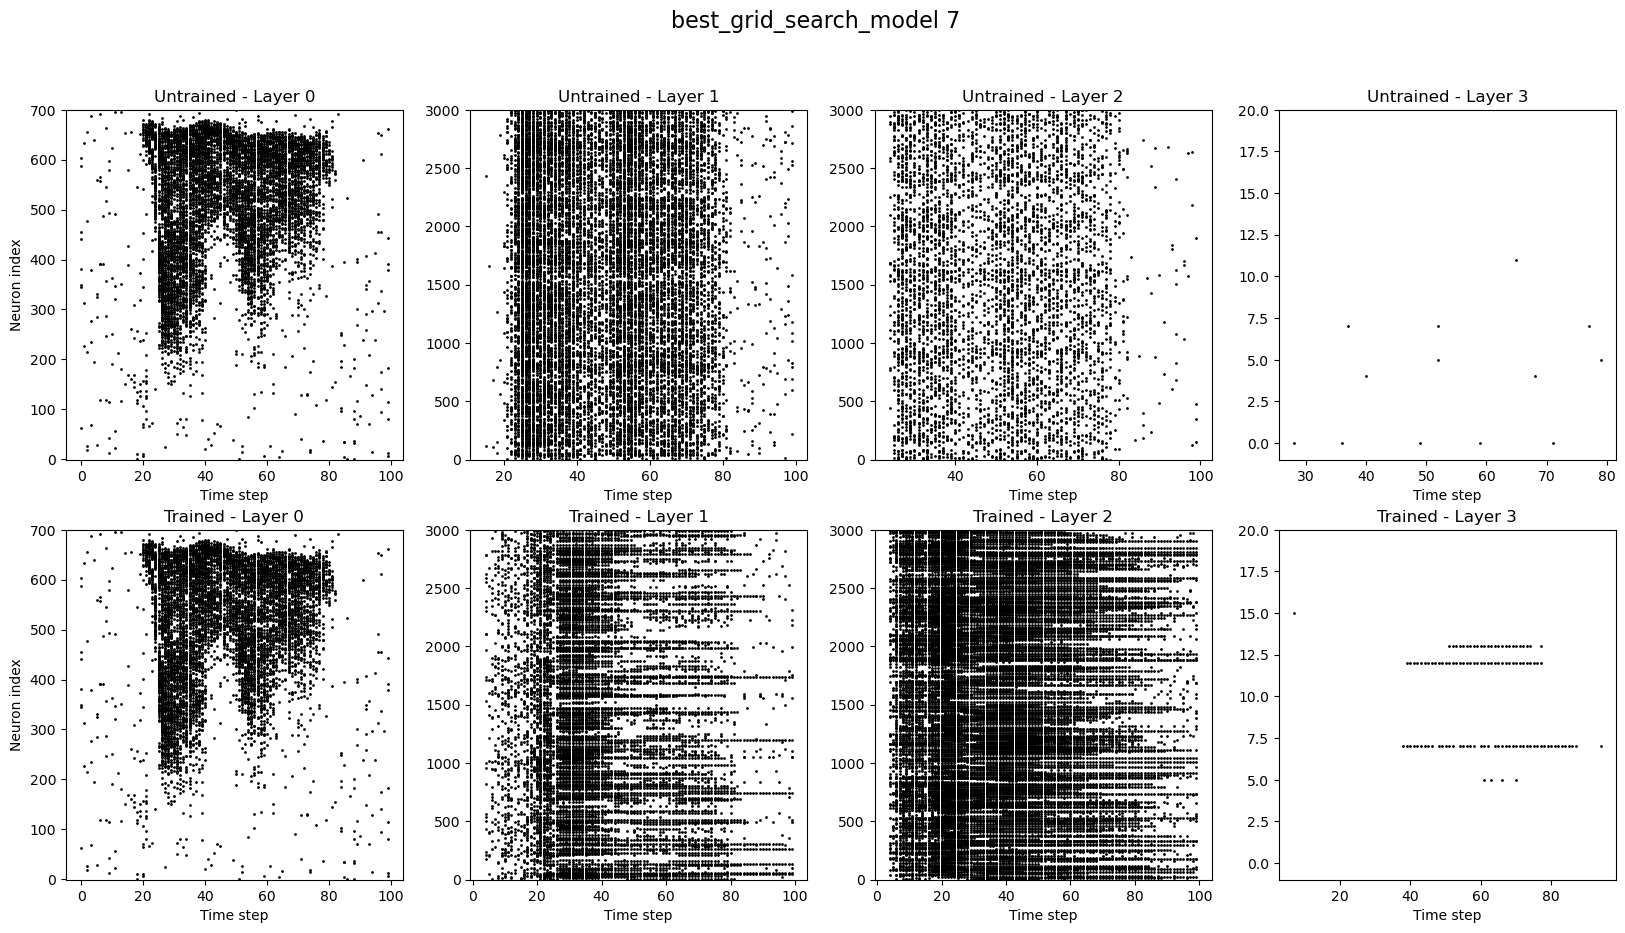

In [9]:
import matplotlib.pyplot as plt
import numpy as np

spike_matrices_untrained = get_spk_matrices(data, best_grid_search_model, selection_index)
spike_matrices_trained = get_spk_matrices(data, best_grid_search_model_trained, selection_index)

fig, axes = plt.subplots(2, len(spike_matrices_untrained), figsize=(20, 10))

fig.suptitle(f"best_grid_search_model {y_selected}", fontsize=16)

for index in range(len(spike_matrices_untrained)):
    spike_matrix_np = spike_matrices_untrained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_untrained = axes[0, index]
    ax_untrained.scatter(times, neurons, s=1, color='black')
    ax_untrained.set_title(f"Untrained - Layer {index}")
    ax_untrained.set_xlabel("Time step")
    ax_untrained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_untrained.set_ylabel("Neuron index")

    spike_matrix_np = spike_matrices_trained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_trained = axes[1, index]
    ax_trained.scatter(times, neurons, s=1, color='black')
    ax_trained.set_title(f"Trained - Layer {index}")
    ax_trained.set_xlabel("Time step")
    ax_trained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_trained.set_ylabel("Neuron index")